In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, random_state=0):
    
    np.random.seed(random_state)
    x = np.zeros((datanum, 10))
    for i in range(10):
        x[:, i:i+1] = np.random.uniform(0, 1,[datanum,1])
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = [x[:, [i]] for i in range(10)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
         + 0.1 * np.exp(-8 * x2 + 4)
         + 3 * np.sin(2 * np.pi * x3 * x4)
         + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X1":{"type":'continuous'},
             'X2':{'type':'continuous'},
             'X3':{'type':'continuous'},
             'X4':{'type':'continuous'},
             'X5':{'type':'continuous'},
             'X6':{'type':'continuous'},
             'X7':{'type':'continuous'},
             'X8':{'type':'continuous'},
             'X9':{'type':'continuous'},
             'X10':{'type':'continuous'},
             'Y':{'type':'target'}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=5000, random_state=0)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
            interact_arch=[20, 10], subnet_arch=[20, 10], 
            lr_bp=0.001, batch_size=200, task_type=task_type, activation_func=tf.nn.tanh, 
            main_effect_epochs=2000, interaction_epochs=2000, tuning_epochs=500, early_stop_thres=100,
            heredity=True, loss_threshold=0.01, reg_clarity=0.0,
            verbose=True, val_ratio=0.2, random_state=0)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.12345, val loss: 0.12218
Main effects training epoch: 2, train loss: 0.11472, val loss: 0.11383
Main effects training epoch: 3, train loss: 0.10256, val loss: 0.10198
Main effects training epoch: 4, train loss: 0.09188, val loss: 0.09139
Main effects training epoch: 5, train loss: 0.08546, val loss: 0.08496
Main effects training epoch: 6, train loss: 0.07851, val loss: 0.07793
Main effects training epoch: 7, train loss: 0.07565, val loss: 0.07516
Main effects training epoch: 8, train loss: 0.06773, val loss: 0.06734
Main effects training epoch: 9, train loss: 0.05547, val loss: 0.05518
Main effects training epoch: 10, train loss: 0.05645, val loss: 0.05613
Main effects training epoch: 11, train loss: 0.04545, val loss: 0.04513
Main effects training epoch: 12, train loss: 0.04376, val loss: 0.04360
Main effects training e

Main effects training epoch: 117, train loss: 0.00959, val loss: 0.00963
Main effects training epoch: 118, train loss: 0.00965, val loss: 0.00963
Main effects training epoch: 119, train loss: 0.00957, val loss: 0.00954
Main effects training epoch: 120, train loss: 0.00964, val loss: 0.00965
Main effects training epoch: 121, train loss: 0.00961, val loss: 0.00966
Main effects training epoch: 122, train loss: 0.00958, val loss: 0.00956
Main effects training epoch: 123, train loss: 0.00957, val loss: 0.00957
Main effects training epoch: 124, train loss: 0.00961, val loss: 0.00956
Main effects training epoch: 125, train loss: 0.00958, val loss: 0.00953
Main effects training epoch: 126, train loss: 0.00955, val loss: 0.00957
Main effects training epoch: 127, train loss: 0.00959, val loss: 0.00959
Main effects training epoch: 128, train loss: 0.00961, val loss: 0.00958
Main effects training epoch: 129, train loss: 0.00956, val loss: 0.00955
Main effects training epoch: 130, train loss: 0.009

Main effects training epoch: 233, train loss: 0.00922, val loss: 0.00923
Main effects training epoch: 234, train loss: 0.00924, val loss: 0.00919
Main effects training epoch: 235, train loss: 0.00924, val loss: 0.00915
Main effects training epoch: 236, train loss: 0.00940, val loss: 0.00936
Main effects training epoch: 237, train loss: 0.00923, val loss: 0.00931
Main effects training epoch: 238, train loss: 0.00921, val loss: 0.00915
Main effects training epoch: 239, train loss: 0.00920, val loss: 0.00921
Main effects training epoch: 240, train loss: 0.00944, val loss: 0.00948
Main effects training epoch: 241, train loss: 0.00923, val loss: 0.00922
Main effects training epoch: 242, train loss: 0.00929, val loss: 0.00924
Main effects training epoch: 243, train loss: 0.00925, val loss: 0.00930
Main effects training epoch: 244, train loss: 0.00920, val loss: 0.00919
Main effects training epoch: 245, train loss: 0.00924, val loss: 0.00921
Main effects training epoch: 246, train loss: 0.009

Interaction training epoch: 45, train loss: 0.00897, val loss: 0.00902
Interaction training epoch: 46, train loss: 0.00893, val loss: 0.00897
Interaction training epoch: 47, train loss: 0.00895, val loss: 0.00897
Interaction training epoch: 48, train loss: 0.00886, val loss: 0.00887
Interaction training epoch: 49, train loss: 0.00881, val loss: 0.00882
Interaction training epoch: 50, train loss: 0.00876, val loss: 0.00876
Interaction training epoch: 51, train loss: 0.00870, val loss: 0.00866
Interaction training epoch: 52, train loss: 0.00873, val loss: 0.00871
Interaction training epoch: 53, train loss: 0.00855, val loss: 0.00852
Interaction training epoch: 54, train loss: 0.00861, val loss: 0.00858
Interaction training epoch: 55, train loss: 0.00855, val loss: 0.00844
Interaction training epoch: 56, train loss: 0.00851, val loss: 0.00842
Interaction training epoch: 57, train loss: 0.00830, val loss: 0.00818
Interaction training epoch: 58, train loss: 0.00823, val loss: 0.00807
Intera

Interaction training epoch: 162, train loss: 0.00698, val loss: 0.00679
Interaction training epoch: 163, train loss: 0.00698, val loss: 0.00678
Interaction training epoch: 164, train loss: 0.00700, val loss: 0.00683
Interaction training epoch: 165, train loss: 0.00707, val loss: 0.00686
Interaction training epoch: 166, train loss: 0.00697, val loss: 0.00678
Interaction training epoch: 167, train loss: 0.00699, val loss: 0.00681
Interaction training epoch: 168, train loss: 0.00720, val loss: 0.00700
Interaction training epoch: 169, train loss: 0.00698, val loss: 0.00681
Interaction training epoch: 170, train loss: 0.00725, val loss: 0.00708
Interaction training epoch: 171, train loss: 0.00699, val loss: 0.00678
Interaction training epoch: 172, train loss: 0.00708, val loss: 0.00691
Interaction training epoch: 173, train loss: 0.00697, val loss: 0.00679
Interaction training epoch: 174, train loss: 0.00698, val loss: 0.00680
Interaction training epoch: 175, train loss: 0.00697, val loss: 

Interaction training epoch: 276, train loss: 0.00699, val loss: 0.00684
Interaction training epoch: 277, train loss: 0.00695, val loss: 0.00677
Interaction training epoch: 278, train loss: 0.00695, val loss: 0.00675
Interaction training epoch: 279, train loss: 0.00695, val loss: 0.00679
Interaction training epoch: 280, train loss: 0.00695, val loss: 0.00679
Interaction training epoch: 281, train loss: 0.00706, val loss: 0.00685
Interaction training epoch: 282, train loss: 0.00701, val loss: 0.00682
Interaction training epoch: 283, train loss: 0.00701, val loss: 0.00681
Interaction training epoch: 284, train loss: 0.00695, val loss: 0.00678
Interaction training epoch: 285, train loss: 0.00701, val loss: 0.00684
Interaction training epoch: 286, train loss: 0.00703, val loss: 0.00682
Interaction training epoch: 287, train loss: 0.00698, val loss: 0.00682
Interaction training epoch: 288, train loss: 0.00697, val loss: 0.00678
Interaction training epoch: 289, train loss: 0.00695, val loss: 

Interaction training epoch: 390, train loss: 0.00547, val loss: 0.00552
Interaction training epoch: 391, train loss: 0.00542, val loss: 0.00546
Interaction training epoch: 392, train loss: 0.00535, val loss: 0.00538
Interaction training epoch: 393, train loss: 0.00532, val loss: 0.00536
Interaction training epoch: 394, train loss: 0.00536, val loss: 0.00546
Interaction training epoch: 395, train loss: 0.00535, val loss: 0.00544
Interaction training epoch: 396, train loss: 0.00522, val loss: 0.00529
Interaction training epoch: 397, train loss: 0.00519, val loss: 0.00527
Interaction training epoch: 398, train loss: 0.00518, val loss: 0.00530
Interaction training epoch: 399, train loss: 0.00520, val loss: 0.00533
Interaction training epoch: 400, train loss: 0.00527, val loss: 0.00536
Interaction training epoch: 401, train loss: 0.00510, val loss: 0.00525
Interaction training epoch: 402, train loss: 0.00511, val loss: 0.00524
Interaction training epoch: 403, train loss: 0.00507, val loss: 

Interaction training epoch: 504, train loss: 0.00454, val loss: 0.00473
Interaction training epoch: 505, train loss: 0.00449, val loss: 0.00466
Interaction training epoch: 506, train loss: 0.00450, val loss: 0.00463
Interaction training epoch: 507, train loss: 0.00447, val loss: 0.00463
Interaction training epoch: 508, train loss: 0.00446, val loss: 0.00461
Interaction training epoch: 509, train loss: 0.00448, val loss: 0.00462
Interaction training epoch: 510, train loss: 0.00454, val loss: 0.00466
Interaction training epoch: 511, train loss: 0.00443, val loss: 0.00457
Interaction training epoch: 512, train loss: 0.00442, val loss: 0.00457
Interaction training epoch: 513, train loss: 0.00441, val loss: 0.00456
Interaction training epoch: 514, train loss: 0.00441, val loss: 0.00457
Interaction training epoch: 515, train loss: 0.00441, val loss: 0.00455
Interaction training epoch: 516, train loss: 0.00439, val loss: 0.00455
Interaction training epoch: 517, train loss: 0.00440, val loss: 

Interaction training epoch: 619, train loss: 0.00372, val loss: 0.00370
Interaction training epoch: 620, train loss: 0.00371, val loss: 0.00366
Interaction training epoch: 621, train loss: 0.00376, val loss: 0.00376
Interaction training epoch: 622, train loss: 0.00370, val loss: 0.00367
Interaction training epoch: 623, train loss: 0.00373, val loss: 0.00372
Interaction training epoch: 624, train loss: 0.00375, val loss: 0.00367
Interaction training epoch: 625, train loss: 0.00379, val loss: 0.00378
Interaction training epoch: 626, train loss: 0.00370, val loss: 0.00363
Interaction training epoch: 627, train loss: 0.00367, val loss: 0.00364
Interaction training epoch: 628, train loss: 0.00368, val loss: 0.00362
Interaction training epoch: 629, train loss: 0.00380, val loss: 0.00370
Interaction training epoch: 630, train loss: 0.00366, val loss: 0.00364
Interaction training epoch: 631, train loss: 0.00366, val loss: 0.00362
Interaction training epoch: 632, train loss: 0.00365, val loss: 

Interaction training epoch: 733, train loss: 0.00324, val loss: 0.00332
Interaction training epoch: 734, train loss: 0.00328, val loss: 0.00336
Interaction training epoch: 735, train loss: 0.00327, val loss: 0.00331
Interaction training epoch: 736, train loss: 0.00325, val loss: 0.00333
Interaction training epoch: 737, train loss: 0.00323, val loss: 0.00328
Interaction training epoch: 738, train loss: 0.00324, val loss: 0.00336
Interaction training epoch: 739, train loss: 0.00321, val loss: 0.00329
Interaction training epoch: 740, train loss: 0.00321, val loss: 0.00331
Interaction training epoch: 741, train loss: 0.00320, val loss: 0.00330
Interaction training epoch: 742, train loss: 0.00321, val loss: 0.00333
Interaction training epoch: 743, train loss: 0.00321, val loss: 0.00328
Interaction training epoch: 744, train loss: 0.00319, val loss: 0.00328
Interaction training epoch: 745, train loss: 0.00321, val loss: 0.00334
Interaction training epoch: 746, train loss: 0.00318, val loss: 

Interaction training epoch: 847, train loss: 0.00294, val loss: 0.00315
Interaction training epoch: 848, train loss: 0.00293, val loss: 0.00322
Interaction training epoch: 849, train loss: 0.00291, val loss: 0.00319
Interaction training epoch: 850, train loss: 0.00292, val loss: 0.00316
Interaction training epoch: 851, train loss: 0.00303, val loss: 0.00322
Interaction training epoch: 852, train loss: 0.00291, val loss: 0.00315
Interaction training epoch: 853, train loss: 0.00291, val loss: 0.00317
Interaction training epoch: 854, train loss: 0.00292, val loss: 0.00320
Interaction training epoch: 855, train loss: 0.00289, val loss: 0.00313
Interaction training epoch: 856, train loss: 0.00289, val loss: 0.00315
Interaction training epoch: 857, train loss: 0.00290, val loss: 0.00314
Interaction training epoch: 858, train loss: 0.00291, val loss: 0.00318
Interaction training epoch: 859, train loss: 0.00290, val loss: 0.00319
Interaction training epoch: 860, train loss: 0.00289, val loss: 

Interaction training epoch: 961, train loss: 0.00269, val loss: 0.00290
Interaction training epoch: 962, train loss: 0.00268, val loss: 0.00290
Interaction training epoch: 963, train loss: 0.00267, val loss: 0.00292
Interaction training epoch: 964, train loss: 0.00267, val loss: 0.00286
Interaction training epoch: 965, train loss: 0.00269, val loss: 0.00293
Interaction training epoch: 966, train loss: 0.00271, val loss: 0.00286
Interaction training epoch: 967, train loss: 0.00265, val loss: 0.00287
Interaction training epoch: 968, train loss: 0.00267, val loss: 0.00287
Interaction training epoch: 969, train loss: 0.00279, val loss: 0.00295
Interaction training epoch: 970, train loss: 0.00270, val loss: 0.00293
Interaction training epoch: 971, train loss: 0.00265, val loss: 0.00285
Interaction training epoch: 972, train loss: 0.00268, val loss: 0.00285
Interaction training epoch: 973, train loss: 0.00280, val loss: 0.00306
Interaction training epoch: 974, train loss: 0.00269, val loss: 

Interaction training epoch: 1075, train loss: 0.00247, val loss: 0.00259
Interaction training epoch: 1076, train loss: 0.00247, val loss: 0.00258
Interaction training epoch: 1077, train loss: 0.00250, val loss: 0.00256
Interaction training epoch: 1078, train loss: 0.00249, val loss: 0.00266
Interaction training epoch: 1079, train loss: 0.00246, val loss: 0.00257
Interaction training epoch: 1080, train loss: 0.00245, val loss: 0.00257
Interaction training epoch: 1081, train loss: 0.00251, val loss: 0.00265
Interaction training epoch: 1082, train loss: 0.00250, val loss: 0.00264
Interaction training epoch: 1083, train loss: 0.00245, val loss: 0.00256
Interaction training epoch: 1084, train loss: 0.00247, val loss: 0.00258
Interaction training epoch: 1085, train loss: 0.00245, val loss: 0.00256
Interaction training epoch: 1086, train loss: 0.00247, val loss: 0.00255
Interaction training epoch: 1087, train loss: 0.00244, val loss: 0.00259
Interaction training epoch: 1088, train loss: 0.002

Interaction training epoch: 1189, train loss: 0.00236, val loss: 0.00250
Interaction training epoch: 1190, train loss: 0.00236, val loss: 0.00247
Interaction training epoch: 1191, train loss: 0.00234, val loss: 0.00249
Interaction training epoch: 1192, train loss: 0.00245, val loss: 0.00253
Interaction training epoch: 1193, train loss: 0.00234, val loss: 0.00245
Interaction training epoch: 1194, train loss: 0.00232, val loss: 0.00244
Interaction training epoch: 1195, train loss: 0.00237, val loss: 0.00252
Interaction training epoch: 1196, train loss: 0.00234, val loss: 0.00246
Interaction training epoch: 1197, train loss: 0.00235, val loss: 0.00249
Interaction training epoch: 1198, train loss: 0.00236, val loss: 0.00249
Interaction training epoch: 1199, train loss: 0.00242, val loss: 0.00257
Interaction training epoch: 1200, train loss: 0.00235, val loss: 0.00248
Interaction training epoch: 1201, train loss: 0.00248, val loss: 0.00265
Interaction training epoch: 1202, train loss: 0.002

Interaction training epoch: 1303, train loss: 0.00229, val loss: 0.00247
Interaction training epoch: 1304, train loss: 0.00224, val loss: 0.00235
Interaction training epoch: 1305, train loss: 0.00221, val loss: 0.00238
Interaction training epoch: 1306, train loss: 0.00224, val loss: 0.00241
Interaction training epoch: 1307, train loss: 0.00222, val loss: 0.00238
Interaction training epoch: 1308, train loss: 0.00226, val loss: 0.00245
Interaction training epoch: 1309, train loss: 0.00223, val loss: 0.00238
Interaction training epoch: 1310, train loss: 0.00226, val loss: 0.00244
Interaction training epoch: 1311, train loss: 0.00220, val loss: 0.00237
Interaction training epoch: 1312, train loss: 0.00222, val loss: 0.00240
Interaction training epoch: 1313, train loss: 0.00224, val loss: 0.00239
Interaction training epoch: 1314, train loss: 0.00220, val loss: 0.00238
Interaction training epoch: 1315, train loss: 0.00231, val loss: 0.00253
Interaction training epoch: 1316, train loss: 0.002

Interaction training epoch: 1417, train loss: 0.00215, val loss: 0.00237
Interaction training epoch: 1418, train loss: 0.00215, val loss: 0.00232
Interaction training epoch: 1419, train loss: 0.00217, val loss: 0.00232
Interaction training epoch: 1420, train loss: 0.00223, val loss: 0.00247
Interaction training epoch: 1421, train loss: 0.00214, val loss: 0.00233
Interaction training epoch: 1422, train loss: 0.00212, val loss: 0.00232
Interaction training epoch: 1423, train loss: 0.00213, val loss: 0.00233
Interaction training epoch: 1424, train loss: 0.00231, val loss: 0.00244
Interaction training epoch: 1425, train loss: 0.00212, val loss: 0.00232
Interaction training epoch: 1426, train loss: 0.00234, val loss: 0.00259
Interaction training epoch: 1427, train loss: 0.00222, val loss: 0.00236
Interaction training epoch: 1428, train loss: 0.00212, val loss: 0.00231
Interaction training epoch: 1429, train loss: 0.00218, val loss: 0.00238
Interaction training epoch: 1430, train loss: 0.002

Interaction training epoch: 1531, train loss: 0.00208, val loss: 0.00226
Interaction training epoch: 1532, train loss: 0.00217, val loss: 0.00239
Interaction training epoch: 1533, train loss: 0.00208, val loss: 0.00232
Interaction training epoch: 1534, train loss: 0.00209, val loss: 0.00231
Interaction training epoch: 1535, train loss: 0.00214, val loss: 0.00236
Interaction training epoch: 1536, train loss: 0.00220, val loss: 0.00239
Interaction training epoch: 1537, train loss: 0.00213, val loss: 0.00233
Interaction training epoch: 1538, train loss: 0.00208, val loss: 0.00225
Interaction training epoch: 1539, train loss: 0.00210, val loss: 0.00227
Interaction training epoch: 1540, train loss: 0.00210, val loss: 0.00234
Interaction training epoch: 1541, train loss: 0.00208, val loss: 0.00231
Interaction training epoch: 1542, train loss: 0.00208, val loss: 0.00228
Interaction training epoch: 1543, train loss: 0.00208, val loss: 0.00225
Interaction training epoch: 1544, train loss: 0.002

Interaction training epoch: 1645, train loss: 0.00205, val loss: 0.00223
Interaction training epoch: 1646, train loss: 0.00204, val loss: 0.00222
Interaction training epoch: 1647, train loss: 0.00203, val loss: 0.00225
Interaction training epoch: 1648, train loss: 0.00206, val loss: 0.00231
Interaction training epoch: 1649, train loss: 0.00203, val loss: 0.00223
Interaction training epoch: 1650, train loss: 0.00213, val loss: 0.00225
Interaction training epoch: 1651, train loss: 0.00210, val loss: 0.00230
Interaction training epoch: 1652, train loss: 0.00211, val loss: 0.00234
Interaction training epoch: 1653, train loss: 0.00205, val loss: 0.00223
Interaction training epoch: 1654, train loss: 0.00210, val loss: 0.00226
Interaction training epoch: 1655, train loss: 0.00206, val loss: 0.00224
Interaction training epoch: 1656, train loss: 0.00207, val loss: 0.00228
Interaction training epoch: 1657, train loss: 0.00204, val loss: 0.00227
Interaction training epoch: 1658, train loss: 0.002

Interaction training epoch: 1759, train loss: 0.00204, val loss: 0.00225
Interaction training epoch: 1760, train loss: 0.00201, val loss: 0.00220
Interaction training epoch: 1761, train loss: 0.00199, val loss: 0.00219
Interaction training epoch: 1762, train loss: 0.00211, val loss: 0.00228
Interaction training epoch: 1763, train loss: 0.00201, val loss: 0.00220
Interaction training epoch: 1764, train loss: 0.00202, val loss: 0.00224
Interaction training epoch: 1765, train loss: 0.00198, val loss: 0.00219
Interaction training epoch: 1766, train loss: 0.00205, val loss: 0.00228
Interaction training epoch: 1767, train loss: 0.00200, val loss: 0.00225
Interaction training epoch: 1768, train loss: 0.00200, val loss: 0.00219
Interaction training epoch: 1769, train loss: 0.00201, val loss: 0.00221
Interaction training epoch: 1770, train loss: 0.00199, val loss: 0.00220
Interaction training epoch: 1771, train loss: 0.00211, val loss: 0.00231
Interaction training epoch: 1772, train loss: 0.002

Interaction training epoch: 1873, train loss: 0.00198, val loss: 0.00219
Interaction training epoch: 1874, train loss: 0.00206, val loss: 0.00228
Interaction training epoch: 1875, train loss: 0.00202, val loss: 0.00220
Interaction training epoch: 1876, train loss: 0.00201, val loss: 0.00217
Interaction training epoch: 1877, train loss: 0.00198, val loss: 0.00219
Interaction training epoch: 1878, train loss: 0.00199, val loss: 0.00220
Interaction training epoch: 1879, train loss: 0.00196, val loss: 0.00214
Interaction training epoch: 1880, train loss: 0.00197, val loss: 0.00216
Interaction training epoch: 1881, train loss: 0.00196, val loss: 0.00214
Interaction training epoch: 1882, train loss: 0.00198, val loss: 0.00215
Interaction training epoch: 1883, train loss: 0.00197, val loss: 0.00216
Interaction training epoch: 1884, train loss: 0.00197, val loss: 0.00217
Interaction training epoch: 1885, train loss: 0.00207, val loss: 0.00227
Interaction training epoch: 1886, train loss: 0.001

Interaction training epoch: 1987, train loss: 0.00195, val loss: 0.00213
Interaction training epoch: 1988, train loss: 0.00207, val loss: 0.00226
Interaction training epoch: 1989, train loss: 0.00201, val loss: 0.00224
Interaction training epoch: 1990, train loss: 0.00199, val loss: 0.00216
Interaction training epoch: 1991, train loss: 0.00193, val loss: 0.00214
Interaction training epoch: 1992, train loss: 0.00198, val loss: 0.00217
Interaction training epoch: 1993, train loss: 0.00200, val loss: 0.00218
Interaction training epoch: 1994, train loss: 0.00200, val loss: 0.00223
Interaction training epoch: 1995, train loss: 0.00195, val loss: 0.00210
Interaction training epoch: 1996, train loss: 0.00197, val loss: 0.00218
Interaction training epoch: 1997, train loss: 0.00195, val loss: 0.00214
Interaction training epoch: 1998, train loss: 0.00197, val loss: 0.00213
Interaction training epoch: 1999, train loss: 0.00195, val loss: 0.00214
Interaction training epoch: 2000, train loss: 0.001

Tuning epoch: 125, train loss: 0.00201, val loss: 0.00217
Tuning epoch: 126, train loss: 0.00193, val loss: 0.00205
Tuning epoch: 127, train loss: 0.00209, val loss: 0.00214
Tuning epoch: 128, train loss: 0.00209, val loss: 0.00226
Tuning epoch: 129, train loss: 0.00194, val loss: 0.00206
Tuning epoch: 130, train loss: 0.00208, val loss: 0.00219
Tuning epoch: 131, train loss: 0.00198, val loss: 0.00212
Tuning epoch: 132, train loss: 0.00194, val loss: 0.00209
Tuning epoch: 133, train loss: 0.00196, val loss: 0.00211
Tuning epoch: 134, train loss: 0.00195, val loss: 0.00210
Tuning epoch: 135, train loss: 0.00204, val loss: 0.00212
Tuning epoch: 136, train loss: 0.00208, val loss: 0.00213
Tuning epoch: 137, train loss: 0.00193, val loss: 0.00203
Tuning epoch: 138, train loss: 0.00205, val loss: 0.00230
Tuning epoch: 139, train loss: 0.00197, val loss: 0.00212
Tuning epoch: 140, train loss: 0.00197, val loss: 0.00206
Tuning epoch: 141, train loss: 0.00197, val loss: 0.00216
Tuning epoch: 

Tuning epoch: 267, train loss: 0.00194, val loss: 0.00211
Tuning epoch: 268, train loss: 0.00197, val loss: 0.00212
Tuning epoch: 269, train loss: 0.00197, val loss: 0.00213
Tuning epoch: 270, train loss: 0.00197, val loss: 0.00216
Tuning epoch: 271, train loss: 0.00196, val loss: 0.00209
Tuning epoch: 272, train loss: 0.00208, val loss: 0.00222
Tuning epoch: 273, train loss: 0.00207, val loss: 0.00213
Tuning epoch: 274, train loss: 0.00191, val loss: 0.00203
Tuning epoch: 275, train loss: 0.00189, val loss: 0.00202
Tuning epoch: 276, train loss: 0.00200, val loss: 0.00215
Tuning epoch: 277, train loss: 0.00189, val loss: 0.00203
Tuning epoch: 278, train loss: 0.00202, val loss: 0.00220
Tuning epoch: 279, train loss: 0.00199, val loss: 0.00222
Tuning epoch: 280, train loss: 0.00190, val loss: 0.00202
Tuning epoch: 281, train loss: 0.00194, val loss: 0.00202
Tuning epoch: 282, train loss: 0.00195, val loss: 0.00213
Tuning epoch: 283, train loss: 0.00191, val loss: 0.00206
Tuning epoch: 

Tuning epoch: 410, train loss: 0.00191, val loss: 0.00206
Tuning epoch: 411, train loss: 0.00195, val loss: 0.00209
Tuning epoch: 412, train loss: 0.00194, val loss: 0.00208
Tuning epoch: 413, train loss: 0.00196, val loss: 0.00206
Tuning epoch: 414, train loss: 0.00189, val loss: 0.00200
Tuning epoch: 415, train loss: 0.00198, val loss: 0.00213
Tuning epoch: 416, train loss: 0.00189, val loss: 0.00206
Tuning epoch: 417, train loss: 0.00187, val loss: 0.00200
Tuning epoch: 418, train loss: 0.00194, val loss: 0.00207
Tuning epoch: 419, train loss: 0.00189, val loss: 0.00202
Tuning epoch: 420, train loss: 0.00190, val loss: 0.00204
Tuning epoch: 421, train loss: 0.00196, val loss: 0.00210
Tuning epoch: 422, train loss: 0.00188, val loss: 0.00200
Tuning epoch: 423, train loss: 0.00189, val loss: 0.00202
Tuning epoch: 424, train loss: 0.00196, val loss: 0.00212
Tuning epoch: 425, train loss: 0.00190, val loss: 0.00206
Tuning epoch: 426, train loss: 0.00187, val loss: 0.00201
Tuning epoch: 

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

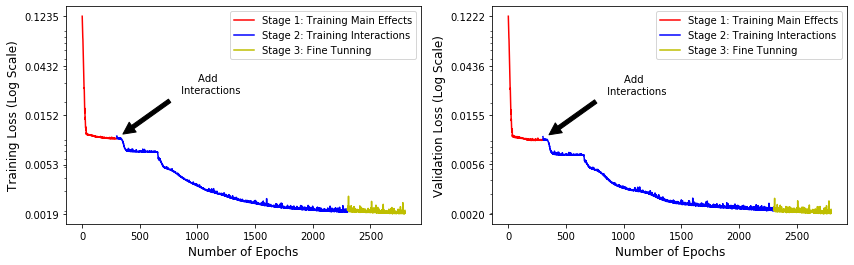

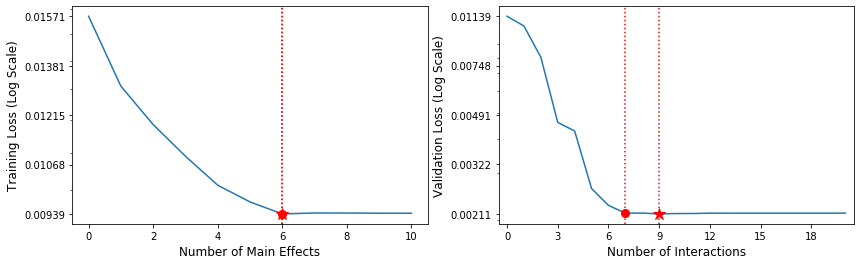

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

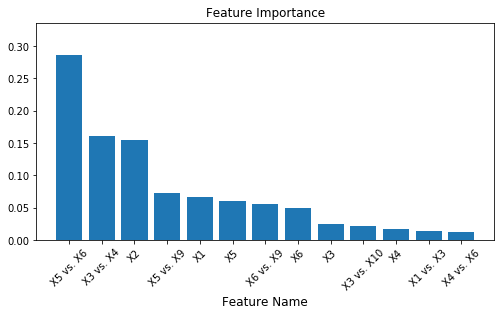

In [6]:
data_dict = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict, save_png=True, folder=simu_dir, name='s1_feature')

Global Visualization

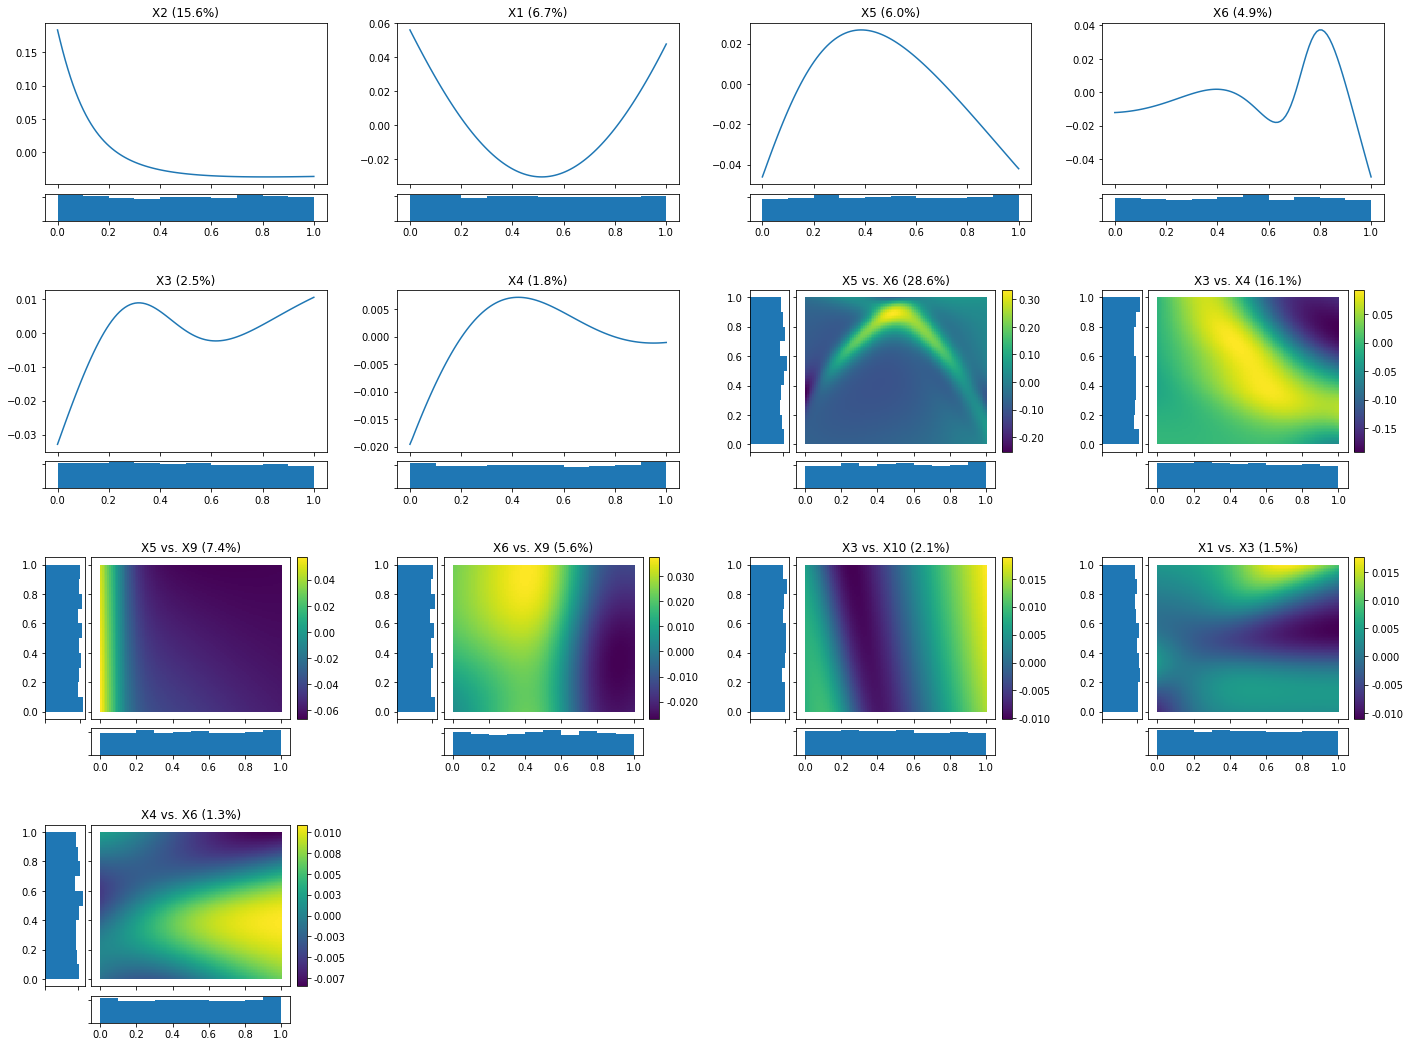

In [7]:
global_visualize_density(data_dict, save_png=True, folder=simu_dir, name='s1_global')

Interpret the prediction of a test sample

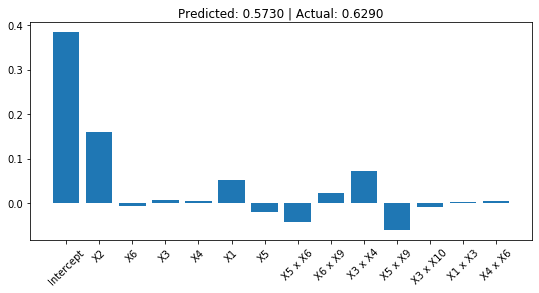

In [8]:
data_dict_local = model.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local, save_png=True, folder=simu_dir, name='s1_local')